<a href="https://colab.research.google.com/github/eridona03/CVexercises/blob/main/ExamEridonaVarosi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, filters, feature, segmentation, color, measure, exposure, morphology, restoration, transform
from skimage.util import img_as_float, img_as_ubyte, random_noise
from sklearn.cluster import KMeans
from sklearn.feature_extraction import image
from sklearn.metrics import silhouette_score
from scipy import ndimage as ndi
from scipy.stats import entropy, kurtosis, skew
import pandas as pd
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Task 1
##Load and visualize the 'coins' image from the skimage built-in datasets. Report the size of the image and range of the pixel grayscale levels.

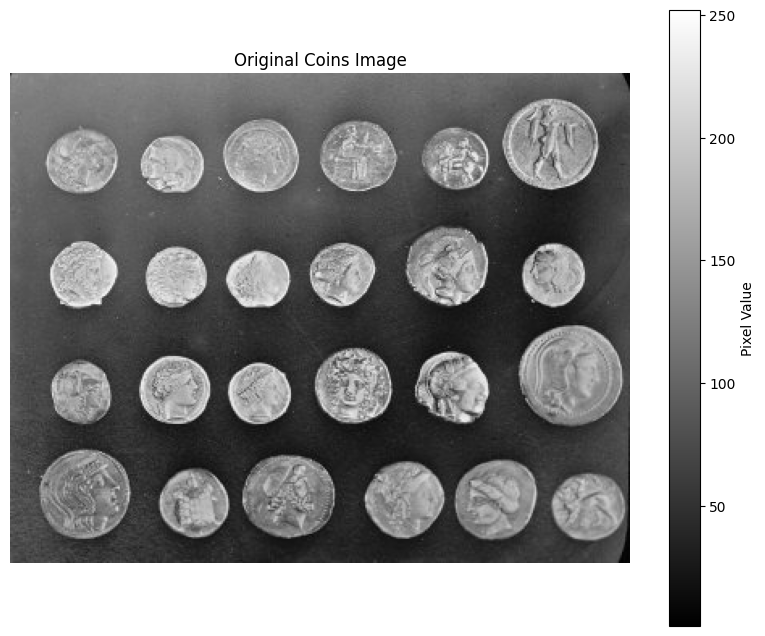

Image shape: (303, 384)
Image dimensions: 303 x 384
Minimum pixel value: 1
Maximum pixel value: 252
Pixel value range: 1 - 252


In [27]:
coins = data.coins()

plt.figure(figsize=(10, 8))
plt.imshow(coins, cmap='gray')
plt.title('Original Coins Image')
plt.colorbar(label='Pixel Value')
plt.axis('off')
plt.show()

print(f"Image shape: {coins.shape}")
print(f"Image dimensions: {coins.shape[0]} x {coins.shape[1]}")
print(f"Minimum pixel value: {coins.min()}")
print(f"Maximum pixel value: {coins.max()}")
print(f"Pixel value range: {coins.min()} - {coins.max()}")

# Task 2
## Represent the histogram of the image. Explain the peaks of the histogram in terms of regions of the image.

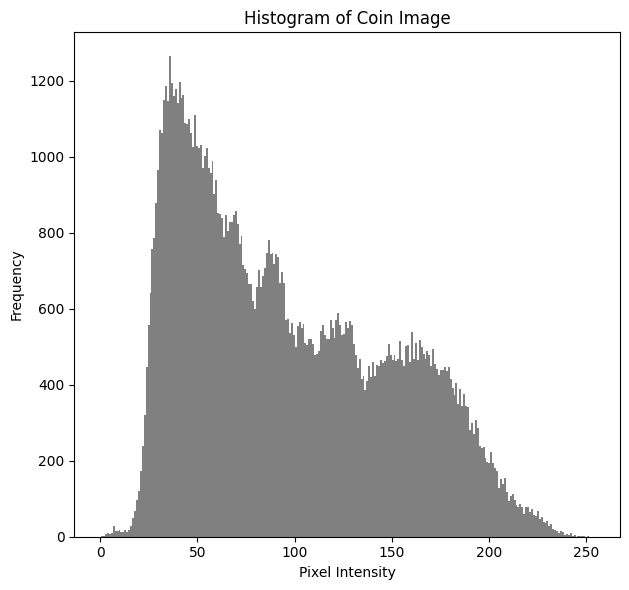

In [28]:
plt.figure(figsize=(12, 6))

hist, bins = np.histogram(coins.flatten(), bins=256, range=[0, 255])
plt.subplot(1, 2, 1)
plt.bar(bins[:-1], hist, width=1, color='gray')
plt.title('Histogram of Coin Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histogram Explanation

The histogram shows pixel intensity distribution in the coins image with a significant peak at value 38, which corresponds to the dark background (highest frequency ~1200 pixels). The middle range (80-150) represents coin edges and shadows, while higher values (150-200) represent the bright coin surfaces. This clear separation between background and coins explains why K-means with k=2 works effectively for segmentation. Despite having different coin sizes, their similar reflectance properties result in comparable intensity distributions without additional significant peaks.

#Task 3
### Apply noise to the image and use the correct function to erase the noise.

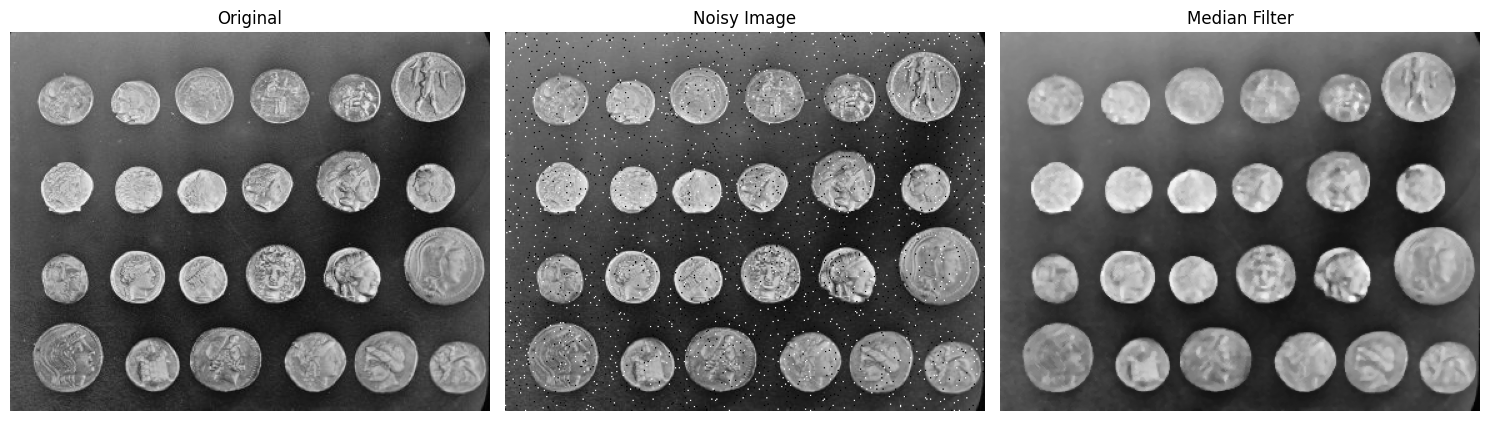

In [29]:
coins_noisy = random_noise(coins, mode='s&p', amount=0.02)
coins_noisy = img_as_ubyte(coins_noisy)

coins_median = filters.median(coins_noisy, footprint=morphology.disk(2))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

axes[0].imshow(coins, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(coins_noisy, cmap='gray')
axes[1].set_title('Noisy Image')
axes[1].axis('off')

axes[2].imshow(coins_median, cmap='gray')
axes[2].set_title('Median Filter')
axes[2].axis('off')

plt.tight_layout()
plt.show()

#Task 4
## Segment the image using a k-means clustering algorithm with k=2 and represent the result

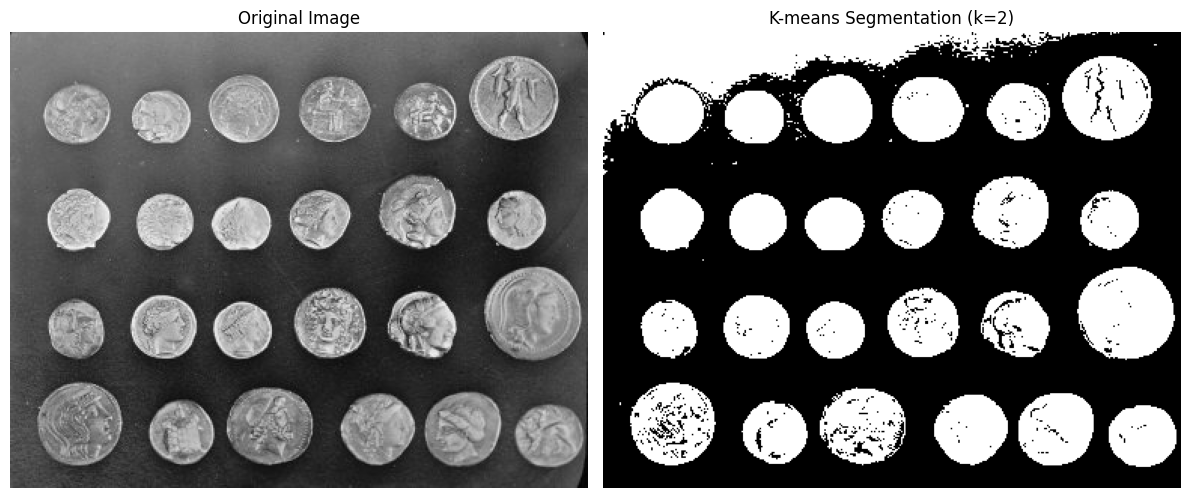

In [30]:
coins_data = coins.reshape((-1, 1))

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(coins_data)

kmeans_labels = kmeans.labels_.reshape(coins.shape)

segmented_img = np.zeros_like(coins)
for i in range(2):
    segmented_img[kmeans_labels == i] = kmeans.cluster_centers_[i]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(coins, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(segmented_img, cmap='gray')
axes[1].set_title('K-means Segmentation (k=2)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Task 5
##Label the objects found in the image. Generate a figure with the original image and the labeled image. How many coins are there in the image?

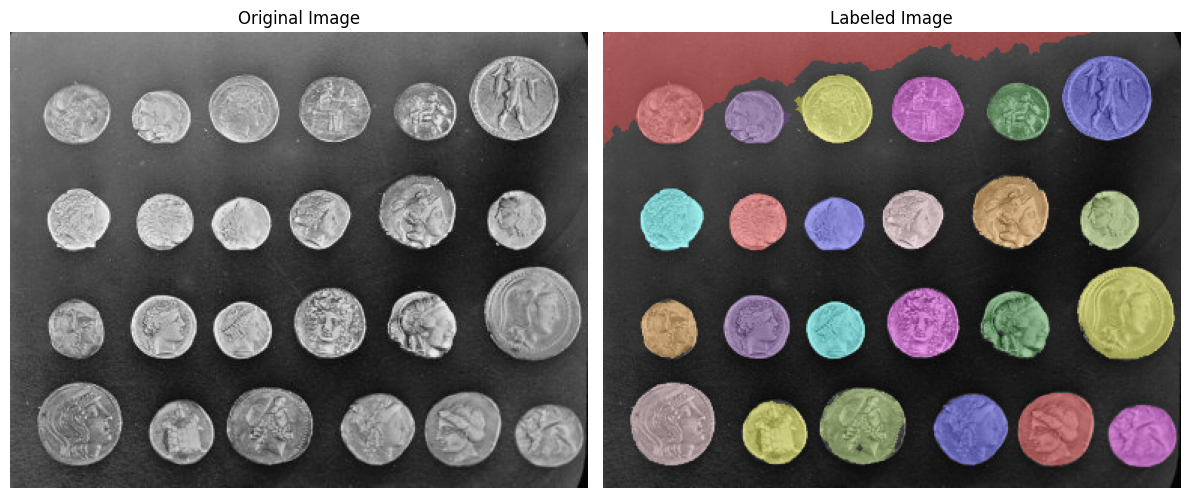

Number of coins detected: 24


In [31]:


from skimage.filters import threshold_otsu
import numpy as np

thresh = threshold_otsu(coins_median)
binary = coins_median > thresh
from skimage.morphology import remove_small_objects, closing, disk

cleaned = remove_small_objects(closing(binary, disk(2)), min_size=100)
from skimage.morphology import remove_small_objects, closing, disk

cleaned = remove_small_objects(closing(binary, disk(2)), min_size=100)

from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.pyplot as plt

labels = label(cleaned)
image_label_overlay = label2rgb(labels, image=coins, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(coins, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(image_label_overlay)
axes[1].set_title('Labeled Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Count real coins (optionally filter regions by size/shape)
regions = regionprops(labels)
num_coins = len(regions)
print(f"Number of coins detected: {num_coins}")

#Task 6
## Extract the area, major axis length and orientation of each coin.Report the average values of the extracted features.Represent a scatterplot of the area vs major axis length.

Number of coins detected: 24
Average coin area: 1968.79 pixels
Average major axis length: 57.98 pixels
Average orientation: 0.08 radians

Properties of each coin:
      Area  Major Axis Length  Orientation  Coin Number
0   9792.0         318.233963    -1.433174            1
1   2608.0          59.240891     1.514125            2
2   1721.0          49.002294     1.384912            3
3   1649.0          47.841664     1.545561            4
4   1234.0          41.402616     1.345724            5
5   1166.0          41.765320     1.501076            6
6   1898.0          50.717836     1.540074            7
7   1324.0          42.345219    -0.887863            8
8   1216.0          40.687974    -1.008868            9
9   1172.0          39.478269    -0.877579           10
10  1127.0          39.185553    -0.927179           11
11  1106.0          39.752757    -1.500007           12
12  3103.0          64.095057     1.382403           13
13  1727.0          47.815071     1.509212           

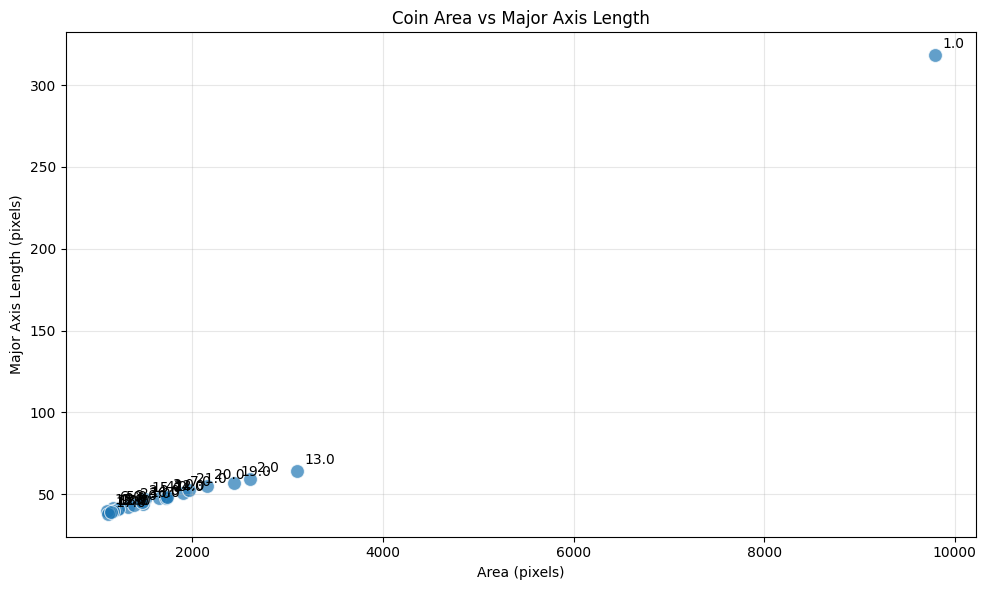

In [32]:
coin_props = regionprops(labels)

areas = []
major_axis_lengths = []
orientations = []

for prop in coin_props:
    areas.append(prop.area)
    major_axis_lengths.append(prop.major_axis_length)
    orientations.append(prop.orientation)

avg_area = np.mean(areas)
avg_major_axis = np.mean(major_axis_lengths)
avg_orientation = np.mean(orientations)

print(f"Number of coins detected: {num_coins}")
print(f"Average coin area: {avg_area:.2f} pixels")
print(f"Average major axis length: {avg_major_axis:.2f} pixels")
print(f"Average orientation: {avg_orientation:.2f} radians")

coin_df = pd.DataFrame({
    'Area': areas,
    'Major Axis Length': major_axis_lengths,
    'Orientation': orientations,
    'Coin Number': range(1, len(areas) + 1)
})

print("\nProperties of each coin:")
print(coin_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Area', y='Major Axis Length', data=coin_df, s=100, alpha=0.7)
plt.title('Coin Area vs Major Axis Length')
plt.xlabel('Area (pixels)')
plt.ylabel('Major Axis Length (pixels)')
plt.grid(alpha=0.3)

for i, row in coin_df.iterrows():
    plt.annotate(f"{row['Coin Number']}",
                 (row['Area'], row['Major Axis Length']),
                 xytext=(5, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()


# Task 7
## Using the labeled regions from the 'coins' image, filter regions to find those with an area greater than 1750 pixels, count how many such coins there are

In [33]:
large_coins = [prop for prop in coin_props if prop.area > 1750]
small_coins = [prop for prop in coin_props if prop.area <= 1750]

print(f"Number of large coins (area > 1750): {len(large_coins)}")
print(f"Number of small coins (area ≤ 1750): {len(small_coins)}")

Number of large coins (area > 1750): 7
Number of small coins (area ≤ 1750): 17


# Task 8
##Generate a 3-panel figure with the original image, the image with the little coins < 1750 (red color) and an image with the big coins > 1750 (blue color).

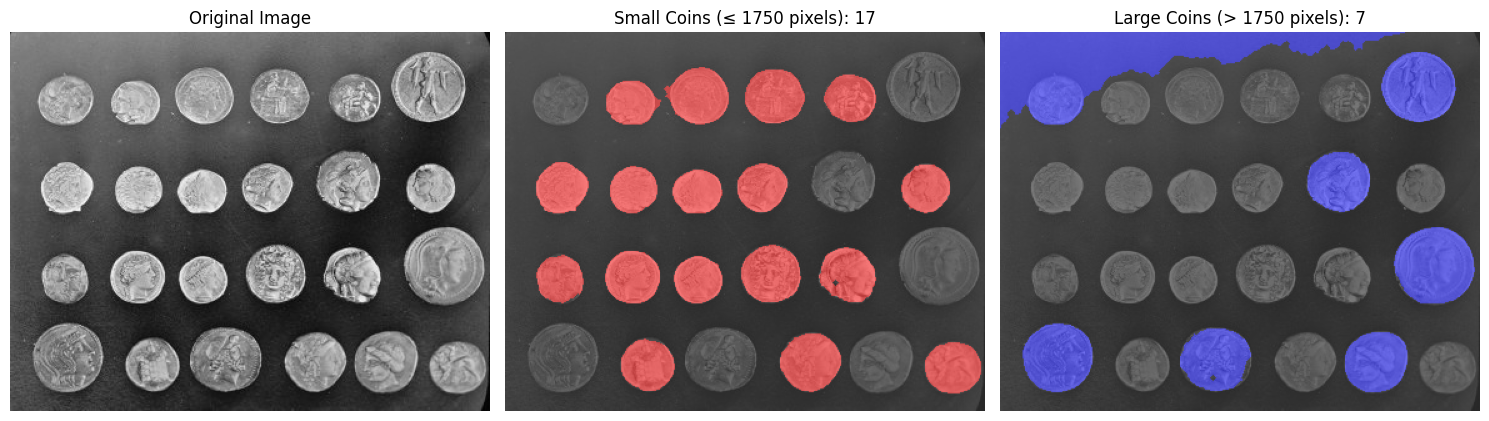

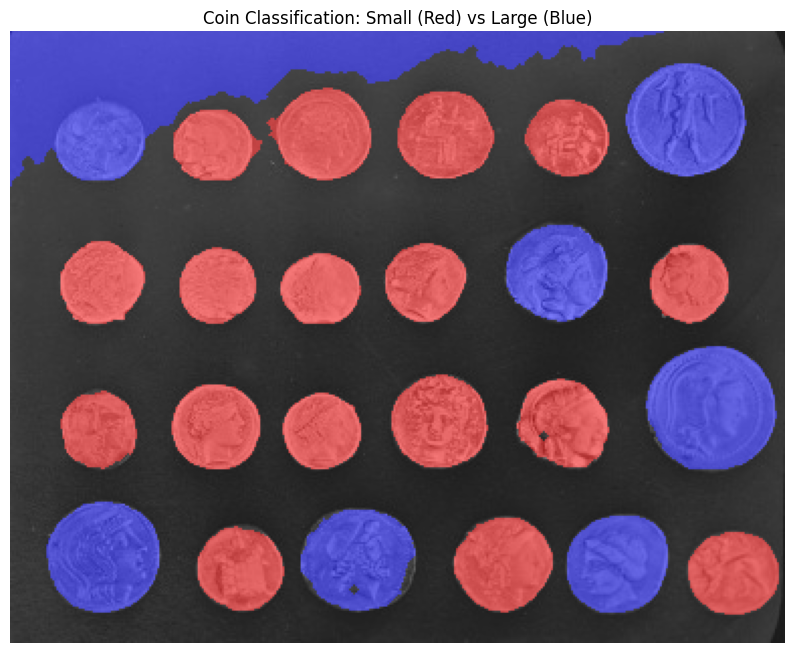

In [34]:
small_coins_mask = np.zeros_like(labels, dtype=bool)
large_coins_mask = np.zeros_like(labels, dtype=bool)

for prop in small_coins:
    small_coins_mask[labels == prop.label] = True

for prop in large_coins:
    large_coins_mask[labels == prop.label] = True

small_coins_img = np.zeros((coins.shape[0], coins.shape[1], 3), dtype=np.uint8)
small_coins_img[small_coins_mask] = [255, 0, 0]  # Red

large_coins_img = np.zeros((coins.shape[0], coins.shape[1], 3), dtype=np.uint8)
large_coins_img[large_coins_mask] = [0, 0, 255]  # Blue

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(coins, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(coins, cmap='gray', alpha=0.7)
axes[1].imshow(small_coins_img, alpha=0.5)
axes[1].set_title(f'Small Coins (≤ 1750 pixels): {len(small_coins)}')
axes[1].axis('off')

axes[2].imshow(coins, cmap='gray', alpha=0.7)
axes[2].imshow(large_coins_img, alpha=0.5)
axes[2].set_title(f'Large Coins (> 1750 pixels): {len(large_coins)}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

combined_img = np.zeros((coins.shape[0], coins.shape[1], 3), dtype=np.uint8)
combined_img[small_coins_mask] = [255, 0, 0]  # Red for small coins
combined_img[large_coins_mask] = [0, 0, 255]  # Blue for large coins

plt.figure(figsize=(10, 8))
plt.imshow(coins, cmap='gray', alpha=0.8)
plt.imshow(combined_img, alpha=0.5)
plt.title('Coin Classification: Small (Red) vs Large (Blue)')
plt.axis('off')
plt.show()


# Task 9
##Describe the main steps required to perform segmentation of an RGB image using an unsupervised clustering algorithm (use other algorithms different than K-Means and compare the results)

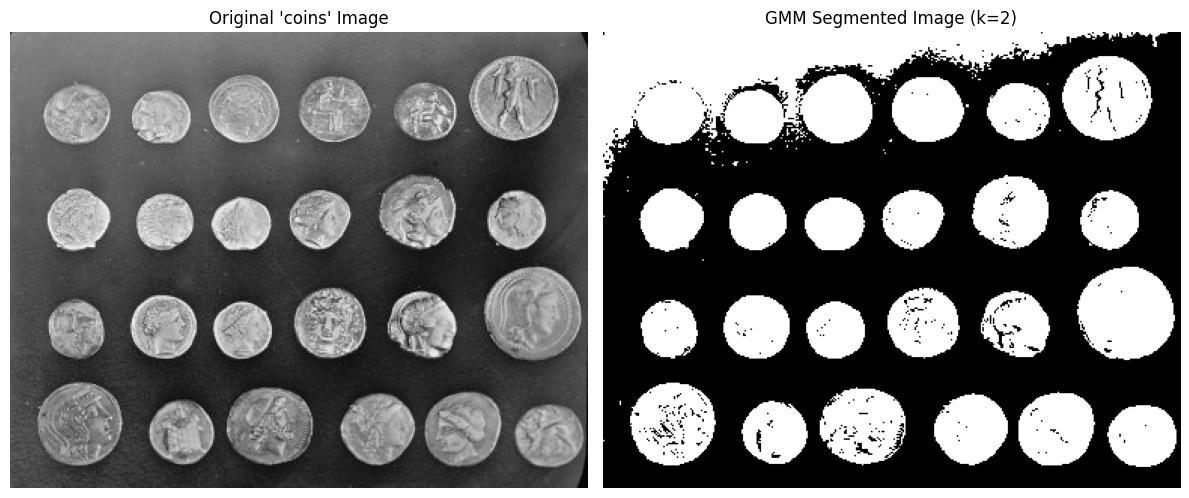

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
from sklearn.mixture import GaussianMixture

image = data.coins()

X = image.reshape(-1, 1)

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X)
labels = gmm.predict(X)

segmented = labels.reshape(image.shape)

if np.mean(image[segmented == 0]) > np.mean(image[segmented == 1]):
    segmented = 1 - segmented


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original 'coins' Image")
ax[0].axis('off')

ax[1].imshow(segmented, cmap='gray')
ax[1].set_title("GMM Segmented Image (k=2)")
ax[1].axis('off')

plt.tight_layout()
plt.show()

1. **Setup**: Import libraries and load the sample coins image
2. **Preprocessing**: Flatten image to 1D array for GMM input
3. **Modeling**: Apply 2-component GMM to separate pixels
4. **Post-processing**: Reshape cluster labels back to original dimensions
5. **Label Correction**: Ensure coins are white (1) and background is black (0)
6. **Visualization**: Display original and segmented images side-by-side

# Task 10
##Extract the main texture features of this image



In [36]:
from skimage.feature import graycomatrix, graycoprops

glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)

contrast = graycoprops(glcm, 'contrast')[0, 0]
dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
energy = graycoprops(glcm, 'energy')[0, 0]
correlation = graycoprops(glcm, 'correlation')[0, 0]

print(f"Contrast: {contrast:.2f}")
print(f"Dissimilarity: {dissimilarity:.2f}")
print(f"Homogeneity: {homogeneity:.2f}")
print(f"Energy: {energy:.2f}")
print(f"Correlation: {correlation:.2f}")

Contrast: 1469.68
Dissimilarity: 20.30
Homogeneity: 0.13
Energy: 0.01
Correlation: 0.74


#Personal discussion

The course was so applicative and until now the most important of the courses I've taken this year, this because it is related directly to the AI profile. The way of teaching was also really nice, as it lacked extra theory but most of it was coding in practice.